In [19]:
from matplotlib import pyplot as plt
import numpy as np
import PyPore
from PyPore.DataTypes import *
import seaborn as sns
import sys
import os
from Analysis_helpers import TraceFile, FilterDerivativeParser


def prepareFiles(directory,inputDict,metaOutput="metadata.json",included_terms=["175"], excluded_terms=[],verbose=False ,acceptedExts={".bin",".opt",".abf"},meta_format="json"):
    for root,dirs,files in os.walk(directory,topdown=True):
        for name in files:
            for key,value in inputDict.items():
                if (root.find(key) != -1 and 
                       all(root.find(in_term) != -1 for in_term in included_terms) and
                       not any(name.find(ex_term) != -1 for ex_term in excluded_terms)): 
                    if os.path.splitext(name)[1]==".bin":
                        value.append(os.path.join(root,name))

# Data Preparation
### load data files, organize them, and parse into events using FilterDerivativeParser

In [15]:
#define keywords in file directory that separates datafiles
experimentfiles={"_ MBP10D":[],"_ MBPMBP10D":[],"_ MBP Nterm":[]}


prepareFiles("C:\\Users\\alito\\OneDrive - Northeastern University\\Wanunu Lab\\NASA project\\Dimer data\\",experimentfiles,excluded_terms=["22_"]) #exclude new data collected in 2022 
experimentfilesmod={}
experiments={}

for key,value in experimentfiles.items():
    print(key[2:]," ")
    experimentfilesmod[key[2:]] = value #Redefine keys to eliminate "_ " in the beginning
    experiments[key[2:]]=[]
    for filename in value:
        print(" ",filename)

print (experiments)

import time
t=time.time()

for key,filenames in experimentfilesmod.items():
    for filename in filenames:
        experiments[key].append(TraceFile(filename))
        #threads.append(threading.Thread(name="thread:"+filename, target=experiments[key][-1].parse, 
        #                   kwargs=dict(parser=MyFilterDerivativeSegmenter(sampling_freq=experiments[key][-1].second,cutoff_freq=5000,low_threshold=0.01,high_threshold=0.015))))
        experiments[key][-1].parse(parser=FilterDerivativeParser(sampling_freq=experiments[key][-1].second,cutoff_freq=5000,low_threshold=0.01,high_threshold=0.015))
print ("elapsed time:",time.time()-t)
_experiments={}

MBP10D  
  C:\Users\alito\OneDrive - Northeastern University\Wanunu Lab\NASA project\Dimer data\alphaHL_ MBP10D_1M KCl_2M GdnHCl_PH7.5  traces 10kHz filter\175mV\B081920_006_trace_10kHz.bin
  C:\Users\alito\OneDrive - Northeastern University\Wanunu Lab\NASA project\Dimer data\alphaHL_ MBP10D_1M KCl_2M GdnHCl_PH7.5  traces 10kHz filter\175mV\B081920_007_trace_10kHz.bin
  C:\Users\alito\OneDrive - Northeastern University\Wanunu Lab\NASA project\Dimer data\alphaHL_ MBP10D_1M KCl_2M GdnHCl_PH7.5  traces 10kHz filter\175mV\B081920_008_trace_10kHz.bin
  C:\Users\alito\OneDrive - Northeastern University\Wanunu Lab\NASA project\Dimer data\alphaHL_ MBP10D_1M KCl_2M GdnHCl_PH7.5  traces 10kHz filter\175mV\B081920_009_trace_10kHz.bin
MBPMBP10D  
  C:\Users\alito\OneDrive - Northeastern University\Wanunu Lab\NASA project\Dimer data\alphaHL_ MBPMBP10D_1M KCl_2M GdnHCl_PH7.5  traces 10kHz filter\175mV\B090120_004_trace_10kHz.bin
  C:\Users\alito\OneDrive - Northeastern University\Wanunu Lab\NASA pro

Text(0.5, 1.0, '')

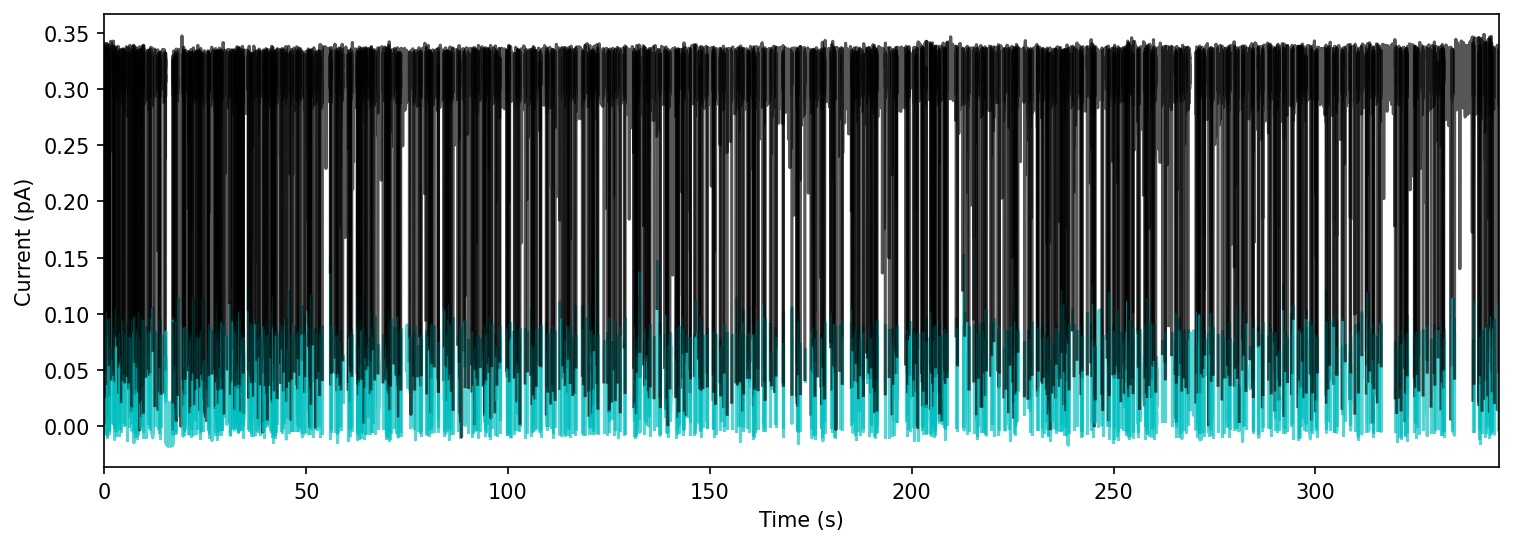

In [23]:
# plot example parsed trace
plt.figure(figsize=(12,4),dpi=150)
experiments['MBPMBP10D'][0].plot()
plt.title("")


In [29]:
#There's a rare artifact from the DAQ card where some portions of data get repeated. 
#This code cleans that up and removes copied events

for key, experiment in experiments.items():
    
    # first select a wide range of events to be used later
    events=[event for file in experiment for event in file.events if event.duration>0.3e-3 and event.duration<20e-3]
    
    #identify duplicates by first comparing exact dwell times and then minima (1 vs all)
    duplicates = [event for event in events if [eventx.duration for eventx in events].count(event.duration) > 1] 
    duplicates= [event for event in duplicates if [eventx.min for eventx in duplicates].count(event.min) > 1]

    #select events that did not show up as duplicates
    select_events=[event for event in events if event not in duplicates]
    
    print(key)
    print("  total:",len(events))
    print("  duplicate free:",len(select_events))
    
    experiments[key]=select_events


MBP10D
  total: 866
  duplicate free: 854
MBPMBP10D
  total: 717
  duplicate free: 713
MBP Nterm
  total: 504
  duplicate free: 488


# Dynamic Time Warping
## Soft-DTW barycenter computation

In [26]:
#import all DTW functionality 
import tslearn
from tslearn.metrics import soft_dtw,gamma_soft_dtw
from tslearn.preprocessing import TimeSeriesResampler
from tslearn.barycenters import softdtw_barycenter,euclidean_barycenter

print (tslearn.__version__)

0.5.2


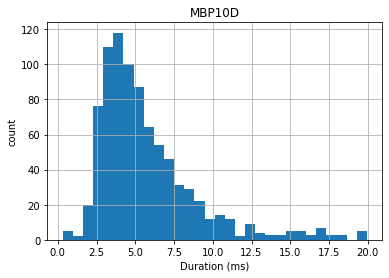

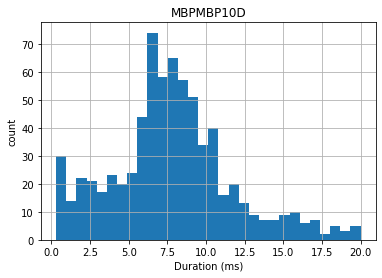

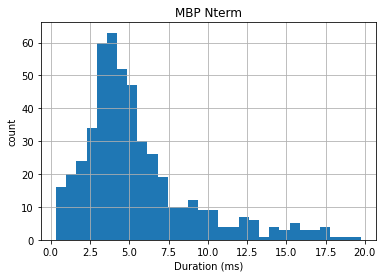

In [32]:
# plot histograms of duration to illustrate what the next filtering step will select
for key,events in experiments.items():
    plt.figure()
    plt.hist([(event.duration*1000) for event in events],bins=30)
    plt.title(key)
    plt.xlabel("Duration (ms)")
    plt.ylabel("count")
    plt.grid()
    

In [34]:
#calculate Barycenter for a given set and plot the curve with the event current backdrops
def barycenter_plot(events,resample_to=400, gamma=None, label="",tol=0.001,c='g'):
    
    #resample all events in the set to a fixed size
    resampler_long=TimeSeriesResampler(sz=resample_to)
    smooth_derivs_resampled=[resampler_long.fit_transform(event.current/event.I_0).ravel() for event in events]
    print("resampling size: ", resample_to)
    
    if gamma is None: # if gamma is not provided..
        gammas=[]
        for i in range (30):
            gammas.append(gamma_soft_dtw(smooth_derivs_resampled[:],len(smooth_derivs_resampled),i)) 
        gamma=np.mean(gammas) #estimate an optimal gamma by averaging many guesses
        print("auto gamma: ",gamma)
    else: # otherwise use the provided gamma
        print("gamma: ",gamma)
        
    # Now calculate the barycenter curve (b) for all events in the set using gamma    
    b=softdtw_barycenter(smooth_derivs_resampled[:],max_iter=800,gamma=gamma,tol=1e-7) 
      
    # first plot the backdrops
    plt.plot (smooth_derivs_resampled[0].ravel(), c='k',alpha=0.2,linewidth=0.2, label="50 resampled events")
    for i in range (1,len(events)):
        plt.plot (smooth_derivs_resampled[i*1].ravel(), c='k',alpha=0.2,linewidth=0.2)
        
    # Then plot the barycenter curve   
    plt.plot (b,c=c,alpha=0.9, label= f'{label} soft DTW barycenter',linewidth=2)
    return(gamma)

filtered selection
91
184
151
sampled events:
70
70
70
resampling size:  300
auto gamma:  1.6476245544756851
resampling size:  300
auto gamma:  2.175190351155768
resampling size:  500
auto gamma:  2.7322184319606744


Text(0.5, -0.01, 'Segment index $j$')

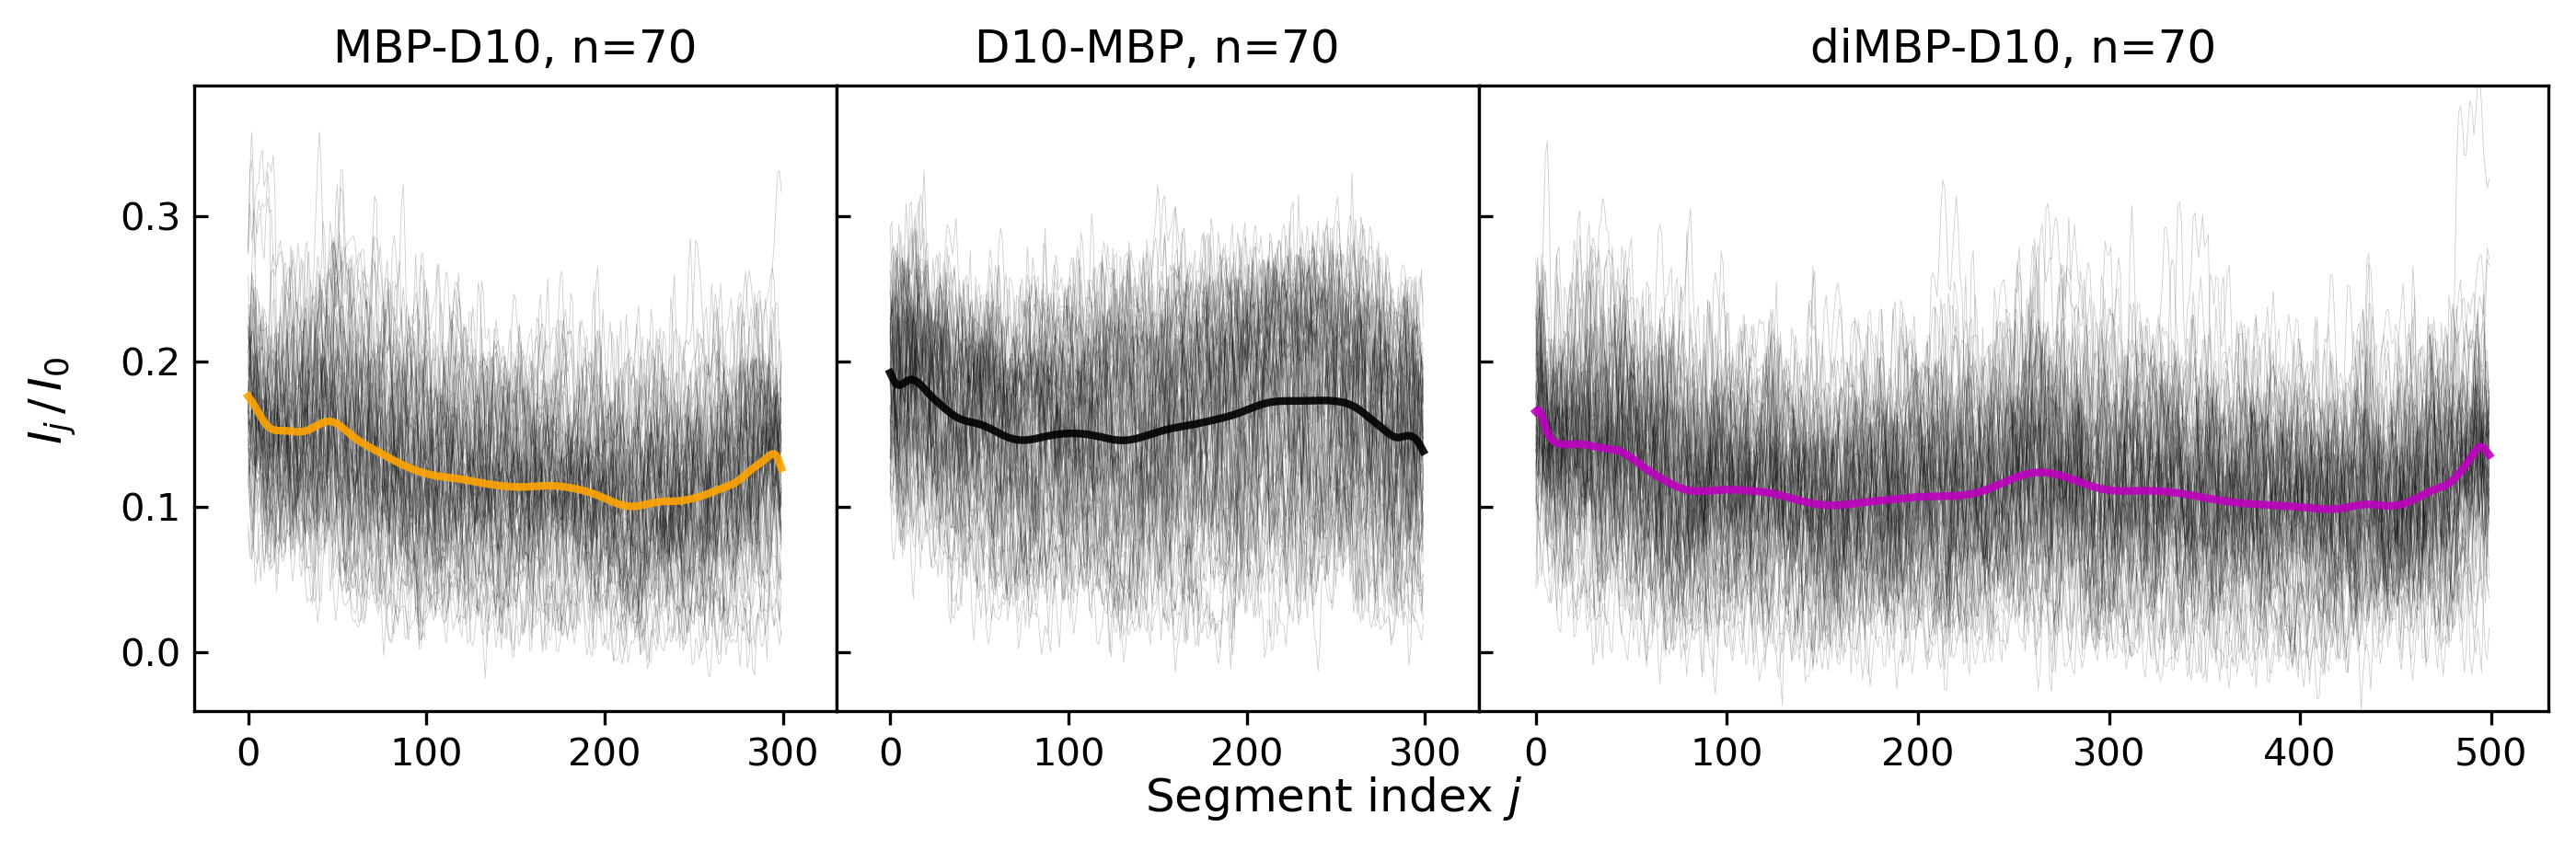

In [35]:


#filter and select a narrow range of events from each variant
events_D10MBP=[event for event in experiments["MBP Nterm"] if event.duration>3.5e-3 and event.duration<4.5e-3 and event.max<0.13]
events_MBPD10=[event for event in experiments["MBP10D"] if event.duration>3.5e-3 and event.duration<4.5e-3 and event.max<0.13]
events_diMBPD10=[event for event in experiments["MBPMBP10D"] if event.duration>6e-3 and event.duration<7.5e-3 and event.max<0.13]
print("filtered selection")
print(len(events_D10MBP))
print(len(events_MBPD10))
print(len(events_diMBPD10))

events_D10MBP=events_D10MBP[:70]
events_MBPD10=events_MBPD10[:140:2]
events_diMBPD10=events_diMBPD10[1:140:2]


from matplotlib import gridspec
print("sampled events:")
print(len(events_D10MBP))
print(len(events_MBPD10))
print(len(events_diMBPD10))

# create 3-panel figure and plot each variant
fig=plt.figure(figsize=(11,3),dpi=300)
gs = gridspec.GridSpec(1, 3, width_ratios=[3,3,5]) 


ax=plt.subplot(gs[0])
gamma=barycenter_plot(events_MBPD10,resample_to=300,label='MBP-D10',c='orange')


ax.set_title(f"MBP-D10, n={len(events_MBPD10)}")
plt.xlim(-30,330)
ax.tick_params('y',direction='in')


ax=plt.subplot(gs[1],sharey=ax)
plt.ylim(-0.01,0.41)
ax.tick_params('y',direction='in')

gamma=barycenter_plot(events_D10MBP,resample_to=300,label='D10-MBP',c='k')
plt.xlim(-30,330)
ax.set_title(f"D10-MBP, n={len(events_D10MBP)}")
plt.setp(ax.get_yticklabels(), visible=False)


ax=plt.subplot(gs[2],sharey=ax)
ax.tick_params('y',direction='in')
gamma=barycenter_plot(events_diMBPD10,resample_to=500,label='diMBP-D10',c='m')

plt.ylim(-0.04,0.39)
plt.xlim(-30,530)
plt.setp(ax.get_yticklabels(), visible=False)
ax.set_title(f"diMBP-D10, n={len(events_diMBPD10)}")

plt.subplots_adjust(wspace=.0)


fig.supylabel(r"$I_j\,/\,I_0$",x=0.07)
fig.supxlabel('Segment index $j$',y=-0.01)

In [ ]:
#save the generated figure
plt.savefig(os.path.join(os.getcwd(),f"dtw_fig_exports\\RevDTW_3.5-4.5_6-7.5.svg"))